In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import timeit
import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Input data
data = np.load('Data//model_data.npy.npz')
pPriceDA = data['arr_0']
pPV = data['arr_1']
pPricePosImb = data['arr_2']
pPriceNegImb = data['arr_3']
n_pv = data['arr_4'].item()
n_dam = data['arr_5'].item()
n_imb = data['arr_6'].item()

In [3]:
# PV installed power
pPmax = 1

In [4]:
# Total number of periods and scenarios
nperiods = 24
nscenarios = n_pv*n_dam*n_imb
# Probability vector
pi = 1/nscenarios # Equiprobable scenarios
pProb = [pi for i in range(nscenarios)]

In [5]:
# Gurobipy model
model = gp.Model('PVmodel')
vBid = model.addVars(nperiods, vtype=GRB.CONTINUOUS, name='bid')
vImbalanceVol = model.addVars(nperiods, nscenarios, vtype=GRB.CONTINUOUS, name='Imbalance_Volume')
vPosImbalanceVol = model.addVars(nperiods, nscenarios, vtype=GRB.CONTINUOUS, name='Positive_Imbalance_Volume')
vNegImbalanceVol = model.addVars(nperiods, nscenarios, vtype=GRB.CONTINUOUS, name='Negative_Imbalance_Volume')
vBinaryImb = model.addVars(nperiods, nscenarios, vtype=GRB.BINARY, name='Binary_Imbalance_Var')


--------------------------------------------
--------------------------------------------

Using license file C:\Users\Antun\gurobi.lic
Academic license - for non-commercial use only


In [6]:
# Objective function
time_start = timeit.default_timer()

profit = gp.quicksum(pProb[s]*(pPriceDA[t][s]*vBid[t] + pPricePosImb[t][s]*vPosImbalanceVol[t,s] - \
                     pPriceNegImb[t][s]*vNegImbalanceVol[t,s]) for t in range(nperiods) for s in range(nscenarios))
model.setObjective(profit, GRB.MAXIMIZE)

time_end = timeit.default_timer()
time_elapsed = time_end - time_start
print('Execution time (hour:min:sec): {}'.format(str(datetime.timedelta(seconds=time_elapsed))))

Execution time (hour:min:sec): 0:00:00.045774


In [7]:
# Constraints
time_start = timeit.default_timer()

model.addConstrs(vImbalanceVol[t,s] == pPV[t][s] - vBid[t] 
                 for t in range(nperiods) for s in range(nscenarios))
model.addConstrs(vImbalanceVol[t,s] == vPosImbalanceVol[t,s] - vNegImbalanceVol[t,s]
                 for t in range(nperiods) for s in range(nscenarios))
model.addConstrs(vPosImbalanceVol[t,s] <= vBinaryImb[t,s]*pPmax
                 for t in range(nperiods) for s in range(nscenarios))
model.addConstrs(vNegImbalanceVol[t,s] <= (1-vBinaryImb[t,s])*pPmax 
                 for t in range(nperiods) for s in range(nscenarios))
model.addConstrs(vBid[t] <= pPmax for t in range(nperiods))

time_end = timeit.default_timer()
time_elapsed = time_end - time_start
print('Execution time (hour:min:sec): {}'.format(str(datetime.timedelta(seconds=time_elapsed))))

Execution time (hour:min:sec): 0:00:00.044719


In [8]:
time_start = timeit.default_timer()

model.optimize()

time_end = timeit.default_timer()
time_elapsed = time_end - time_start
print('Execution time (hour:min:sec): {}'.format(str(datetime.timedelta(seconds=time_elapsed))))

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 888 rows, 888 columns and 1968 nonzeros
Model fingerprint: 0x810efa9b
Variable types: 672 continuous, 216 integer (216 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 1e+00]
Found heuristic solution: objective 131.1370274
Presolve removed 888 rows and 888 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 131.137 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.311370273866e+02, best bound 1.311370273866e+02, gap 0.0000%
Execution time (hour:min:sec): 0:00:00.041181


In [9]:
vBidvals = []
for index in vBid.keys():
    vBidvals.append(vBid[index].x)
vBidvals = pd.Series(vBidvals)

In [10]:
vNegImbVol = pd.DataFrame()
for period, scenario in vNegImbalanceVol.keys():
    vNegImbVol.loc[period, scenario] = vNegImbalanceVol[period, scenario].x

In [11]:
vPosImbVol = pd.DataFrame()
for period, scenario in vPosImbalanceVol.keys():
    vPosImbVol.loc[period, scenario] = vPosImbalanceVol[period, scenario].x

In [12]:
vPosImbVol

,0,1,2,3,4,5,6,7,8
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019819,0.019819,0.019819
5,0.000000,0.000000,0.000000,0.026106,0.026106,0.026106,0.070590,0.070590,0.070590
6,0.036420,0.036420,0.036420,0.000000,0.000000,0.000000,0.100277,0.100277,0.100277
7,0.000381,0.000381,0.000381,0.000000,0.000000,0.000000,0.184241,0.184241,0.184241
8,0.279078,0.279078,0.279078,0.058304,0.058304,0.058304,0.000000,0.000000,0.000000
9,0.466956,0.466956,0.466956,0.211752,0.211752,0.211752,0.000000,0.000000,0.000000


In [13]:
PV1 = pPV[:, 0]
PV2 = pPV[:, n_dam*n_imb]
PV3 = pPV[:, n_pv*n_dam*n_imb-1]

In [14]:
DAM1 = pPriceDA[:,0]
DAM2 = pPriceDA[:,1]
DAM3 = pPriceDA[:,2]

In [15]:
PosImbPrice1 = pPricePosImb[:, 0]
PosImbPrice2 = pPricePosImb[:, 1]
PosImbPrice3 = pPricePosImb[:, 2]

In [16]:
NegImbPrice1 = pPriceNegImb[:, 0]
NegImbPrice2 = pPriceNegImb[:, 1]
NegImbPrice3 = pPriceNegImb[:, 2]

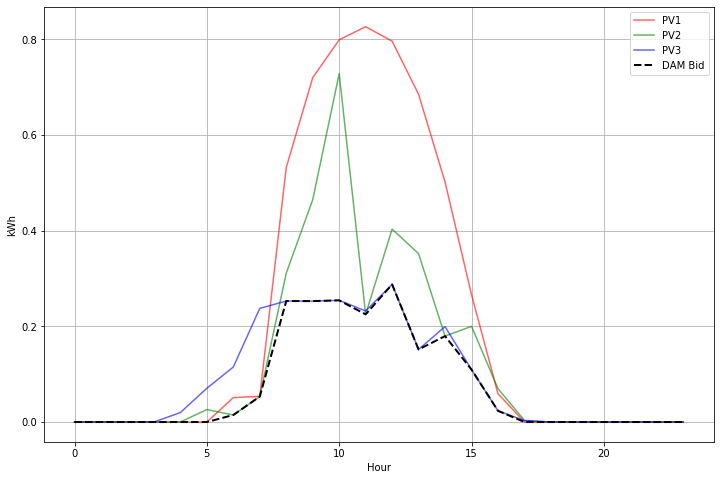

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(PV1, color='red', alpha=0.6, label='PV1')
ax.plot(PV2, color='green', alpha=0.6, label='PV2')
ax.plot(PV3, color='blue', alpha=0.6, label='PV3')
ax.plot(vBidvals, color='k', lw=2, ls='--', label='DAM Bid')
ax.grid()
ax.set_xlabel('Hour')
ax.set_ylabel('kWh')
ax.legend()

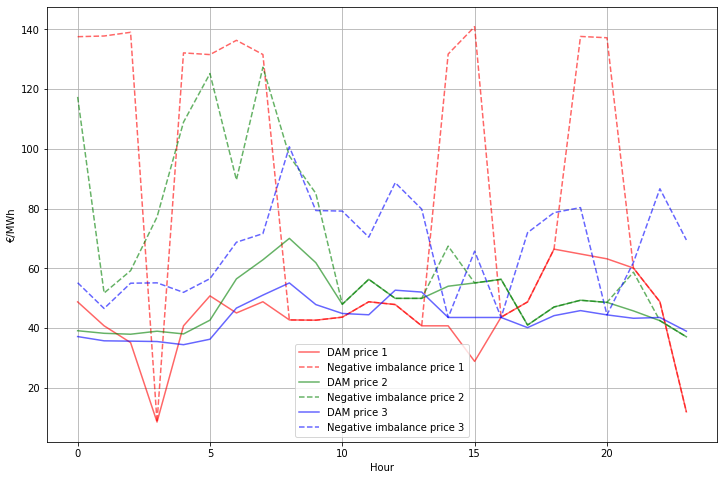

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
alpha_val = 0.6
ax.plot(DAM1, color='red', alpha=alpha_val, label='DAM price 1')
ax.plot(NegImbPrice1, color='red', alpha=alpha_val, ls='--', label='Negative imbalance price 1')
ax.plot(DAM2, color='green', alpha=alpha_val, label='DAM price 2')
ax.plot(NegImbPrice2, color='green', alpha=alpha_val, ls='--', label='Negative imbalance price 2')
ax.plot(DAM3, color='blue', alpha=alpha_val, label='DAM price 3')
ax.plot(NegImbPrice3, color='blue', alpha=alpha_val, ls='--', label='Negative imbalance price 3')
# ax.plot(vBidvals, color='blue', lw=2, ls='--', label='DAM Bid')
ax.grid()
ax.set_xlabel('Hour')
ax.set_ylabel('€/MWh')
ax.legend()

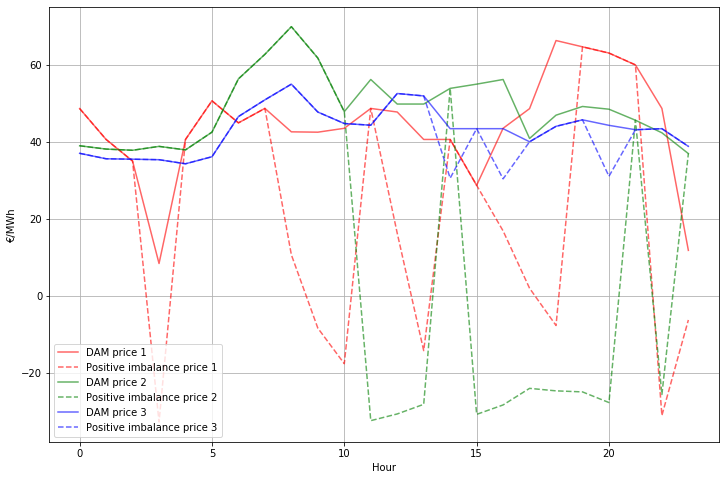

In [19]:
fig, ax = plt.subplots(figsize=(12,8))
alpha_val = 0.6
ax.plot(DAM1, color='red', alpha=alpha_val, label='DAM price 1')
ax.plot(PosImbPrice1, color='red', alpha=alpha_val, ls='--', label='Positive imbalance price 1')
ax.plot(DAM2, color='green', alpha=alpha_val, label='DAM price 2')
ax.plot(PosImbPrice2, color='green', alpha=alpha_val, ls='--', label='Positive imbalance price 2')
ax.plot(DAM3, color='blue', alpha=alpha_val, label='DAM price 3')
ax.plot(PosImbPrice3, color='blue', alpha=alpha_val, ls='--', label='Positive imbalance price 3')
# ax.plot(vBidvals, color='blue', lw=2, ls='--', label='DAM Bid')
ax.grid()
ax.set_xlabel('Hour')
ax.set_ylabel('€/MWh')
ax.legend()